In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR

In [2]:
data_dir = Path(ROOT_DIR, 'ble_data')
agent = 'quantile'
all_paths = {
    'all': [f / 'metrics' / 'console' / 'console.log' for f in (data_dir / 'features_all' / agent).iterdir()],
    'mean': [f / 'metrics' / 'console' / 'console.log' for f in (data_dir / 'features_mean' / agent).iterdir()]
}
def moving_avg(x, mode='valid', w=10):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [3]:
all_results = {}
ep_pattern = re.compile("Episode (\d+) (reward: .*)")

# for each feature configuration
for feature, paths in all_paths.items():
    all_results[feature] = {}
    
    all_results[feature]['reward'] = []
    
    # we iterate through the console.log paths
    for p in paths:
        
        rewards = []
        with open(p) as fp:
            lines = fp.readlines()
            for line in lines:
                line_results = {}
                
                # we first parse all properties into a dict
                all_properties = [l.strip() for l in line.split(',')]
                matches = ep_pattern.search(all_properties[0])
                assert matches is not None
                episode_num = matches.group(1)
                all_properties[0] = matches.group(2)
                
                for p in all_properties:
                    k_v = p.split(':')
                    line_results[k_v[0]] = k_v[1].strip()
                
                # Add what we want to all_results
                rewards.append(float(line_results['reward']))
                
        all_results[feature]['reward'].append(moving_avg(np.array(rewards), w=20))
        
    all_results[feature]['reward'] = np.array(all_results[feature]['reward'])

In [11]:
for res in all_results['mean']['reward']:
    print(res.shape)

(1061,)
(861,)
(861,)
(861,)
(861,)
(861,)
(1061,)
(1061,)
(861,)
(1061,)


In [4]:
# get mean and stderr
all_to_plot = {}

for feature, res in all_results.items():
    rewards = res['reward']
    
    mean_over_seeds = np.mean(rewards, axis=0)
    std_err_over_seeds = np.std(rewards, axis=0) / rewards.shape[0]
    
    all_to_plot[feature] = {
        'x': np.arange(rewards.shape[1]), 'mean': mean_over_seeds, 'stderr': std_err_over_seeds
    }

plot_info = {
    'all': { 'color': 'blue', 'label': 'mean + variance' },
    'mean': { 'color': 'green', 'label': 'mean only' }

}

ValueError: operands could not be broadcast together with shapes (1061,) (861,) 

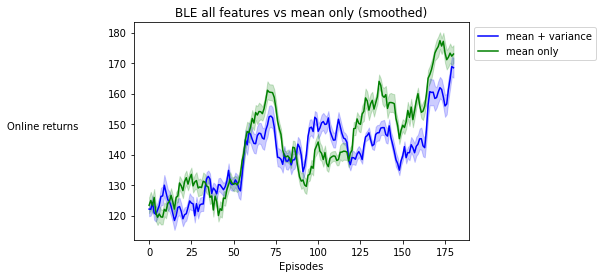

In [18]:
fig, ax = plt.subplots()

for feature, to_plot in all_to_plot.items():
    x = to_plot['x']
    means = to_plot['mean']
    stderr = to_plot['stderr']
    
    ax.plot(x, means, label=plot_info[feature]['label'], color=plot_info[feature]['color'])
    ax.fill_between(x, means - stderr, means + stderr,
                         color=plot_info[feature]['color'], alpha=0.2)

ax.set_xlabel('Episodes')
ax.set_title('BLE all features vs mean only (smoothed)')
ax.set_ylabel(f"Online returns", rotation=0, labelpad=65)

plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')